## Experiments using `sklearn` for image classification

In [1]:
%matplotlib inline

In [2]:
import time
import warnings
import operator
from functools import partial, wraps

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
np.set_printoptions(precision=3, suppress=True)

In [4]:
sns.set_context('notebook', font_scale=1.5)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import FeatureAgglomeration
from sklearn.feature_selection import (SelectKBest, SelectFromModel, SelectFdr, SelectPercentile, 
                                       f_classif, mutual_info_classif, RFE, RFECV)
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import (LassoCV, RidgeClassifierCV)
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, make_scorer

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.pipeline import Pipeline

## Read data

In [6]:
df = pd.read_csv('dat2_features_no_blue.csv')

In [7]:
df.groupby('class')['class_id'].mean()

class
blue_bg                   1.0
distal_acinar_tubule2     2.0
proximal_acinar_tubule    3.0
Name: class_id, dtype: float64

In [8]:
X = df.ix[:, :-3]
y = df.ix[:, -3].astype('int')

## Preprocessing

In [9]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
X_scaled = scaler.transform(X)

In [11]:
X_scaled.mean(axis=0)

array([-0.,  0.,  0., ..., -0., -0., -0.])

In [12]:
X_scaled.std(axis=0)

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

## Dimension reduction expriments

In [13]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [14]:
X_pca = pca.transform(X_scaled)

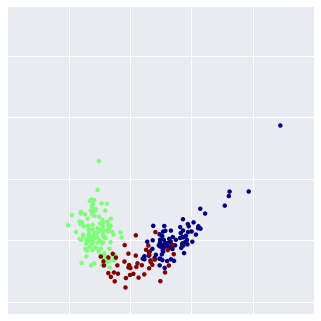

In [15]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax =plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

In [16]:
tsne = TSNE(n_components=2, random_state=1)

In [17]:
X_tsne = tsne.fit_transform(X_scaled)

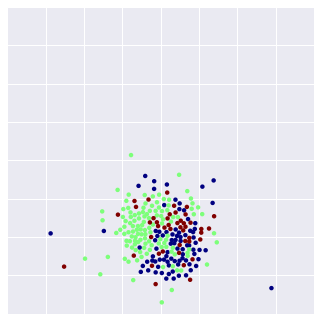

In [18]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax =plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

In [19]:
agg = FeatureAgglomeration(n_clusters=2)

In [20]:
X_agg = agg.fit_transform(X_scaled)

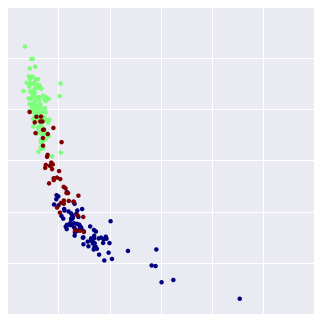

In [21]:
plt.scatter(X_agg[:, 0], X_agg[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax =plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

## Feature selection experiments

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    X_best = SelectKBest(f_classif, k=2).fit_transform(X_scaled, y)

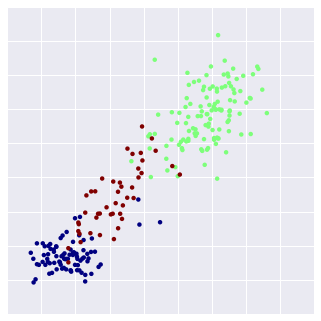

In [23]:
plt.scatter(X_best[:, 0], X_best[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax =plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

In [24]:
X_mi = SelectKBest(mutual_info_classif, k=2).fit_transform(X_scaled, y)

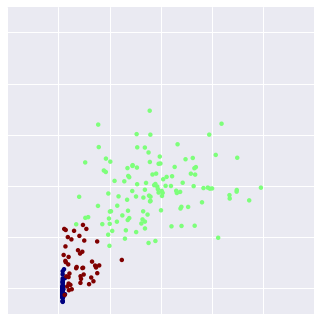

In [25]:
plt.scatter(X_mi[:, 0], X_mi[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax =plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

In [26]:
svc = SVC(kernel="linear", C=1)
X_rfe = (RFE(estimator=svc, n_features_to_select=2)
         .fit_transform(X_scaled, y))

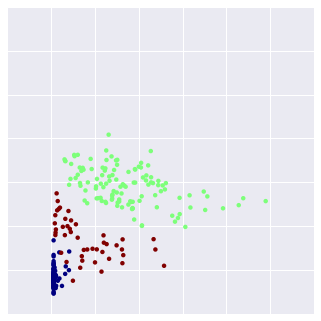

In [27]:
plt.scatter(X_rfe[:, 0], X_rfe[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax =plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

## Classification experiments

In [28]:
lasso = LassoCV()
sfm_lasso = SelectFromModel(lasso, threshold=0.01)
X_lasso = sfm_lasso.fit_transform(X_scaled, y)

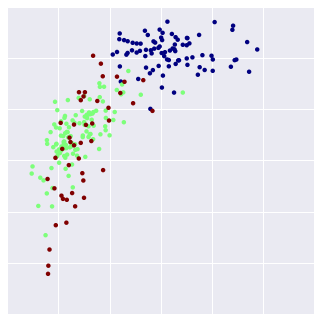

In [29]:
plt.scatter(X_lasso[:, 0], X_lasso[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax =plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

In [30]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_scaled, y)
sfm_rf = SelectFromModel(rf, prefit=True)
X_rf = sfm_rf.transform(X_scaled)

In [31]:
idx = np.argsort(rf.feature_importances_[rf.feature_importances_ > 0])[::-1]
X_rf = X_rf[:, idx]

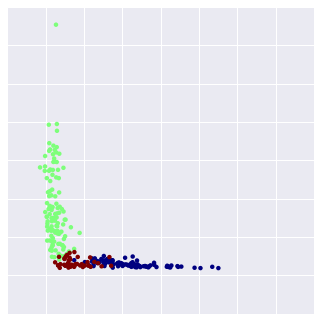

In [32]:
plt.scatter(X_rf[:, 0], X_rf[:, 1], edgecolors='none', c=y, s=20, cmap='jet')
plt.axis('square')
ax =plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
pass

## Classification pipeline experiments

In [33]:
alphas=[0.01, 0.1, 1.0, 10.0, 100.0]

In [34]:
clfs = [
    RidgeClassifierCV(alphas=alphas),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [35]:
try:
    scores
except:
    scores = {}

for clf in clfs:
    if clf.__class__.__name__ in scores:
        continue
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        pipe = Pipeline([
          # ('feature_selection', SelectFdr()),
          ('classification', clf)
        ])
        start = time.clock()
        pipe.fit(X_scaled, y)
        score = cross_val_score(pipe, X_scaled, y, scoring='accuracy')
        elapsed = time.clock() - start
        scores[clf.__class__.__name__] = score.mean(), elapsed, score

## Sort by average cross-validation accuracy

In [36]:
for k, v in sorted(scores.items(), key=lambda x: x[1][0], reverse=True):
    print('%-40s' % k, '%8.2f' % v[0], '%8.2f' % v[1], v[2])

SVC                                          0.96     0.48 [ 0.94   0.964  0.988]
RidgeClassifierCV                            0.96     0.45 [ 0.928  0.964  0.975]
MLPClassifier                                0.95   235.77 [ 0.904  0.964  0.975]
KNeighborsClassifier                         0.94     0.66 [ 0.964  0.952  0.901]
AdaBoostClassifier                           0.90    12.34 [ 0.843  0.916  0.938]
DecisionTreeClassifier                       0.89     0.60 [ 0.867  0.928  0.889]
GaussianNB                                   0.87     0.27 [ 0.855  0.904  0.864]
RandomForestClassifier                       0.87     0.20 [ 0.819  0.892  0.889]
QuadraticDiscriminantAnalysis                0.45     4.24 [ 0.542  0.325  0.469]


## Sort by time taken

In [37]:
for k, v in sorted(scores.items(), key=lambda x: x[1][1], reverse=False):
    print('%-40s' % k, '%8.2f' % v[0], '%8.2f' % v[1], v[2])

RandomForestClassifier                       0.87     0.20 [ 0.819  0.892  0.889]
GaussianNB                                   0.87     0.27 [ 0.855  0.904  0.864]
RidgeClassifierCV                            0.96     0.45 [ 0.928  0.964  0.975]
SVC                                          0.96     0.48 [ 0.94   0.964  0.988]
DecisionTreeClassifier                       0.89     0.60 [ 0.867  0.928  0.889]
KNeighborsClassifier                         0.94     0.66 [ 0.964  0.952  0.901]
QuadraticDiscriminantAnalysis                0.45     4.24 [ 0.542  0.325  0.469]
AdaBoostClassifier                           0.90    12.34 [ 0.843  0.916  0.938]
MLPClassifier                                0.95   235.77 [ 0.904  0.964  0.975]
